In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Transformation / Preprocessing Work

In [14]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

# Focus only on the final 4 --> Equity Indices, Fixed Income, and Commodities.
binary_df = pd.DataFrame(columns=["Stock", "Bonds", "Commodities"], index=response_df.index)
binary_df['Stock'] = response_df['Equity Indices Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Bonds'] = response_df['Fixed Income Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Commodities'] = response_df['Commodities Market'].apply(lambda x: 1 if x > 0 else 0)

dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = binary_df.iloc[:training_ends, :], binary_df.iloc[training_ends:test_ends, :], binary_df.iloc[test_ends:, :]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [15]:
def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Multiple Input CNN

In [16]:
# define a fx. to split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [17]:
# Still predicting equities --> col_num 0 in our y data
n_steps = 12
train_dataset = np.hstack((X_train.values, y_train.values[:, 0].reshape(y_train.shape[0], 1)))
X_train, y_train = split_sequences(train_dataset, n_steps)
test_dataset = np.hstack((X_test.values, y_test.values[:, 0].reshape(y_test.shape[0], 1)))
X_test, y_test = split_sequences(test_dataset, n_steps)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((205, 12, 58), (205,), (109, 12, 58), (109,))

In [18]:
# Define the model.
n_features = X_train.shape[2]
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(50, activation='relu'))
cnn.add(tf.keras.layers.Dense(1))
cnn.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 64)            7488      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 23,589
Trainable params: 23,589
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 0.6847 - accuracy: 0.4585 - val_loss: 0.3927 - val_accuracy: 0.6606
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 4.5766 - accuracy: 0.5938

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 15ms/step - loss: 1.4422 - accuracy: 0.5902 - val_loss: 0.4392 - val_accuracy: 0.4587
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.2890 - accuracy: 0.5756 - val_loss: 0.3644 - val_accuracy: 0.5229
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.3900 - accuracy: 0.4927 - val_loss: 0.4771 - val_accuracy: 0.6514
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.2223 - accuracy: 0.6634 - val_loss: 0.3544 - val_accuracy: 0.5321
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2224 - accuracy: 0.6634 - val_loss: 0.3527 - val_accuracy: 0.5229
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2147 - accuracy: 0.6927 - val_loss: 0.4253 - val_accuracy: 0.6055
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2010 - accuracy: 0.6927 - val_loss: 0.4210 - val_accuracy: 0.6055
Epoch 9/100
7/7 [===============

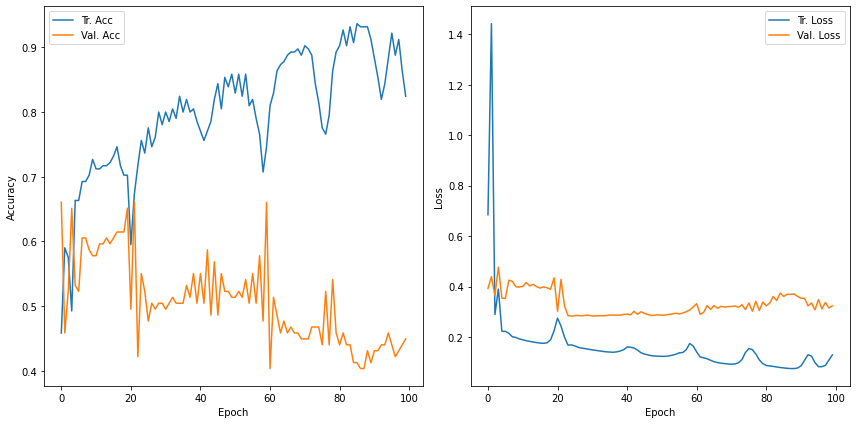

In [19]:
history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "Simple Multi CNN")

### Analysis.

Overall, the model is performing okay. There is some presence of overfitting, particulalry when we observed the Accruacy Chart. There are a few things we can do, similar to the simple input CNN:
1. Regularization
2. Weight Initialization
3. Dropout

In [20]:
###########################
# Leverage Regularization #
###########################
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn.add(tf.keras.layers.Dense(1))
cnn.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 11, 64)            7488      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 23,589
Trainable params: 23,589
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 0s 19ms/step - loss: 2.3644 - accuracy: 0.4780 - val_loss: 2.5479 - val_accuracy: 0.4312
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 12.7598 - accuracy: 0.4062

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 17ms/step - loss: 4.6558 - accuracy: 0.5024 - val_loss: 1.8657 - val_accuracy: 0.6055
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 1.7476 - accuracy: 0.5268 - val_loss: 1.7505 - val_accuracy: 0.3945
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 1.8629 - accuracy: 0.5220 - val_loss: 1.8645 - val_accuracy: 0.3394
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 1.6394 - accuracy: 0.5463 - val_loss: 1.6907 - val_accuracy: 0.4037
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.5768 - accuracy: 0.6049 - val_loss: 1.6187 - val_accuracy: 0.5413
Epoch 7/100
7/7 [==============================] - 0s 18ms/step - loss: 1.5572 - accuracy: 0.6293 - val_loss: 1.6007 - val_accuracy: 0.5505
Epoch 8/100
7/7 [==============================] - 0s 17ms/step - loss: 1.5161 - accuracy: 0.6000 - val_loss: 1.6110 - val_accuracy: 0.4220
Epoch 9/100
7/7 [===============

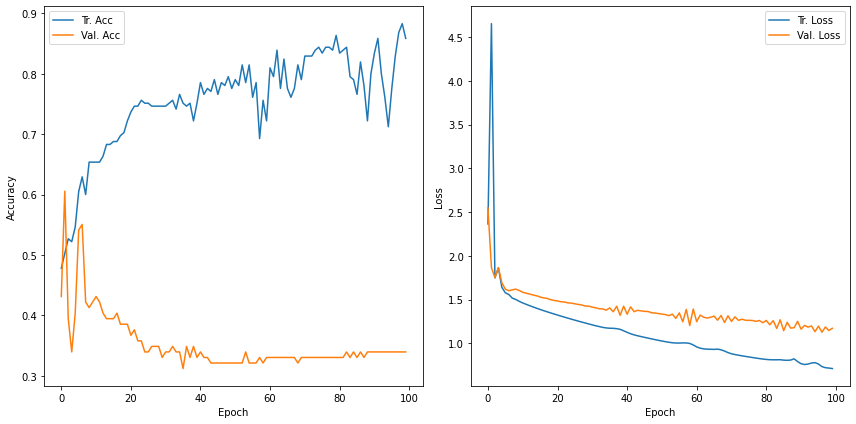

In [21]:
history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "Simple Multi CNN w/ Regularization")

This obiviously hurt more than it helped in terms of performance and the problem of under versus over fitting.

In [22]:
###########################
##        Dropout        ##
###########################
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(1))
cnn.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 11, 64)            7488      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                16050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Epoch 1/100
7/7 [==============================] - 0s 20ms/step - loss: 2.6623 - accuracy: 0.4927 - val_loss: 2.2923 - val_accuracy: 0.3211
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 10.7889 - accuracy: 0.5938

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 17ms/step - loss: 4.0344 - accuracy: 0.6000 - val_loss: 2.6333 - val_accuracy: 0.3394
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 1.9453 - accuracy: 0.5512 - val_loss: 2.8106 - val_accuracy: 0.3394
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 1.7102 - accuracy: 0.4976 - val_loss: 2.7665 - val_accuracy: 0.3394
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 1.7261 - accuracy: 0.4683 - val_loss: 2.3702 - val_accuracy: 0.3394
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 1.6352 - accuracy: 0.5122 - val_loss: 2.0427 - val_accuracy: 0.3394
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 1.5638 - accuracy: 0.5512 - val_loss: 1.9360 - val_accuracy: 0.3394
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 1.5312 - accuracy: 0.6049 - val_loss: 1.7724 - val_accuracy: 0.3486
Epoch 9/100
7/7 [===============

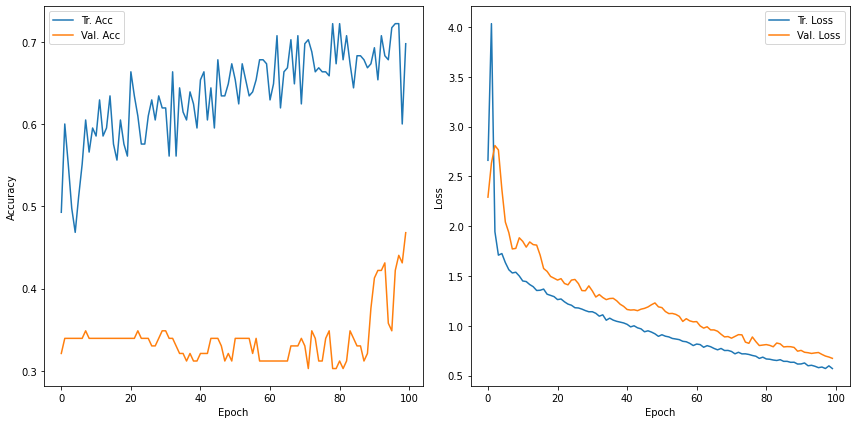

In [23]:
history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "Simple Multi CNN w/ Regularization")